In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
print(tf.__version__)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv
2.6.4


In [2]:
base_fp = '/kaggle/input/digit-recognizer'
train_fp = os.path.join(base_fp, 'train.csv')
test_fp = os.path.join(base_fp, 'test.csv')

train = pd.read_csv(train_fp)
test = pd.read_csv(test_fp)

In [3]:
train.head(5)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
test.head(5)

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:>

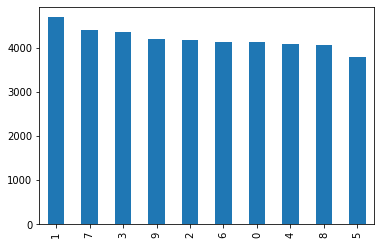

In [5]:
train['label'].value_counts().plot.bar()

In [6]:
import random

def row_to_image(df_row):
    im_size = int(28 * 28)
    im_vec = df_row[-im_size:]
    image_arr = np.array(im_vec).reshape(28, 28, 1)
    return image_arr / 255

def show_examples(df):
    total_num = df.shape[0]
    indices = random.sample(range(0, total_num), 9)
    fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10, 6))
    for ax, i in zip(axs.flatten(), indices):
        img = row_to_image(df.iloc[i])
        ax.imshow(img)

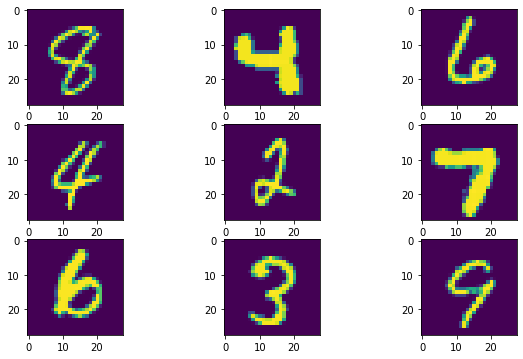

In [7]:
show_examples(train)

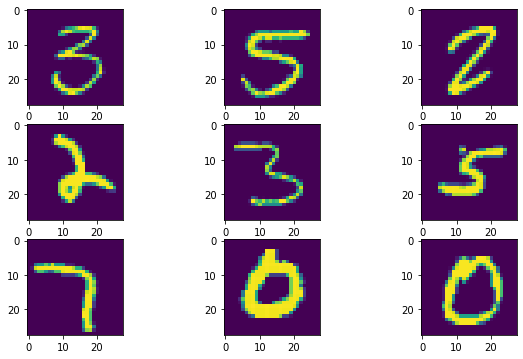

In [8]:
show_examples(test)

In [9]:
x_train_total = []
y_train_total = []

for i in range(train.shape[0]):
    x_train_total.append(row_to_image(train.iloc[i]))
    y_train_total.append(int(train.iloc[i]['label']))

In [10]:
print('Total training set is of length: {}, with elements in shape: {}'.format(len(x_train_total), x_train_total[0].shape))
print('Labels are of length: {}, of type: {}'.format(len(y_train_total), type(y_train_total[0])))

Total training set is of length: 42000, with elements in shape: (28, 28, 1)
Labels are of length: 42000, of type: <class 'int'>


Label is: 6



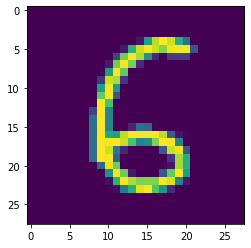

In [11]:
indices = np.arange(len(y_train_total), dtype=int)
np.random.seed(42)
np.random.shuffle(indices)

x_train_shuffled = np.array(x_train_total)[indices]
y_train_shuffled = np.array(y_train_total)[indices]

# Check shuffled
plt.imshow(x_train_shuffled[5])
print('Label is: {}\n'.format(y_train_shuffled[5]))

In [12]:
split_ratio = 0.95
split_index = int(len(y_train_total) * split_ratio)

x_train = x_train_shuffled[:split_index]
y_train = y_train_shuffled[:split_index]

x_valid = x_train_shuffled[split_index:]
y_valid = y_train_shuffled[split_index:]

assert len(x_train) == len(y_train), 'Train set length mismatch'
assert len(x_valid) == len(y_valid), 'Validation set length mismatch'

print('Train set length: {}\nValidation set length: {}'.format(len(y_train), len(y_valid)))

Train set length: 39900
Validation set length: 2100


In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range = 10,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.1,
    zoom_range = 0.1,
    fill_mode = 'nearest'
)

In [14]:
class DigitRecognizer(tf.keras.Model):
    def __init__(self):
        super().__init__(self)
        self.input_layer = tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=[28,28,1])
#         self.conv1_layer = tf.keras.layers.Conv2D(64, (3,3), activation='relu')
#         self.conv2_layer = tf.keras.layers.Conv2D(32, (3,3), activation='relu')
        self.max_pooling_layer = tf.keras.layers.MaxPooling2D(2,2)
        self.flatten_layer = tf.keras.layers.Flatten()
#         self.dense1_layer = tf.keras.layers.Dense(256, activation='relu')
        self.dense2_layer = tf.keras.layers.Dense(128, activation='relu')
        self.dropout_layer = tf.keras.layers.Dropout(0.2)
        self.output_layer = tf.keras.layers.Dense(10, activation='softmax')
        
    def call(self, input, training=None):
        x = self.input_layer(input)
        x = self.max_pooling_layer(x)
#         x = self.conv1_layer(x)
#         x = self.max_pooling_layer(x)
#         x = self.conv2_layer(x)
#         x = self.max_pooling_layer(x)
        x = self.flatten_layer(x)
#         x = self.dense1_layer(x)
#         x = self.dropout_layer(x)
        x = self.dense2_layer(x)
        x = self.dropout_layer(x)
        x = self.output_layer(x)
        return x

In [15]:
model = DigitRecognizer()
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Example prediction
example_prediction = model(np.expand_dims(x_train[0], axis=0))
print(example_prediction.shape)

2022-06-05 15:04:20.541769: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-05 15:04:20.700671: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-05 15:04:20.701527: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-05 15:04:20.702736: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

(1, 10)


In [16]:
model.summary()
init_weights = model.get_weights()

Model: "digit_recognizer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  1384576   
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  1290      
Total params: 1,386,506
Trainable params: 1,386,506
Non-trainable params: 0
________________________________________

In [17]:
TRAIN = True

In [18]:
if TRAIN:

    epochs = 15

    model.set_weights(init_weights)

    history = model.fit(
        datagen.flow(x_train, y_train, batch_size=32),
        validation_data=(x_valid, y_valid),
        steps_per_epoch=len(x_train) / 32,
        epochs=epochs
    )
    
    model.save_weights('/kaggle/working/mk0_weights')
    np.save('/kaggle/working/mk0_history.npy', history.history)

2022-06-05 15:04:29.829370: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15
1246/1246 [==============================] - 14s 11ms/step - loss: 0.6847 - accuracy: 0.7761 - val_loss: 0.2077 - val_accuracy: 0.9424
Epoch 2/15
1246/1246 [==============================] - 14s 11ms/step - loss: 0.3358 - accuracy: 0.8966 - val_loss: 0.1655 - val_accuracy: 0.9514
Epoch 3/15
1246/1246 [==============================] - 14s 11ms/step - loss: 0.2650 - accuracy: 0.9165 - val_loss: 0.0984 - val_accuracy: 0.9743
Epoch 4/15
1246/1246 [==============================] - 14s 11ms/step - loss: 0.2299 - accuracy: 0.9279 - val_loss: 0.0911 - val_accuracy: 0.9752
Epoch 5/15
1246/1246 [==============================] - 14s 11ms/step - loss: 0.2090 - accuracy: 0.9360 - val_loss: 0.1086 - val_accuracy: 0.9719
Epoch 6/15
1246/1246 [==============================] - 14s 11ms/step - loss: 0.1898 - accuracy: 0.9396 - val_loss: 0.0767 - val_accuracy: 0.9810
Epoch 7/15
1246/1246 [==============================] - 15s 12ms/step - loss: 0.1783 - accuracy: 0.9462 - val_loss: 0.1383 -

In [19]:
if not TRAIN:
    model.load_weights('/kaggle/working/mk0_weights')
    history=np.load('/kaggle/working/mk0_history.npy',allow_pickle='TRUE').item()

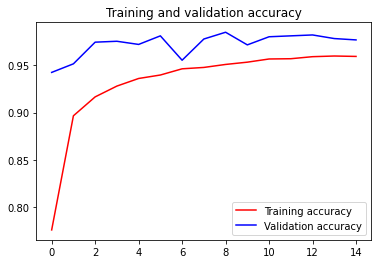

<Figure size 432x288 with 0 Axes>

In [20]:
history = history.history if TRAIN else history

acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

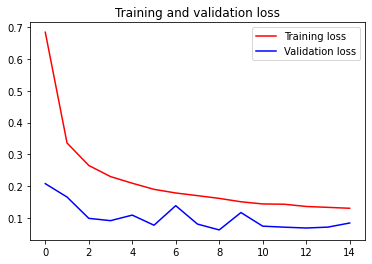

<Figure size 432x288 with 0 Axes>

In [21]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()

In [22]:
x_test = []

for i in range(test.shape[0]):
    x_test.append(row_to_image(test.iloc[i]))
    
x_test = np.array(x_test)

Prediction: 2


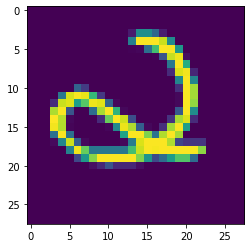

In [23]:
# Sample Prediction
ind = random.randint(0, x_test.shape[0])

pred = model.predict(np.expand_dims(x_test[ind], axis=0))
print('Prediction: {}'.format(np.argmax(pred[0])))
plt.imshow(x_test[ind])

In [24]:
predictions = model.predict(x_test, batch_size=10)

In [25]:
preds = np.argmax(predictions, axis=1)
ids = np.arange(1, len(preds) + 1)

<AxesSubplot:>

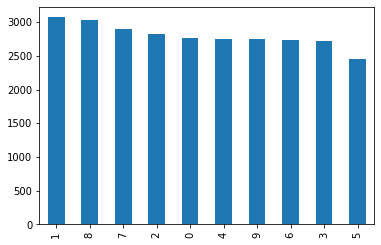

In [26]:
my_submission = pd.DataFrame({'ImageId': ids, 'Label': preds})
my_submission['Label'].value_counts().plot.bar()

In [27]:
my_submission.head(5)

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


2


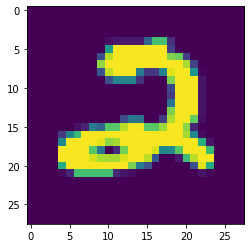

In [28]:
print(my_submission.iloc[0]['Label'])
plt.imshow(x_test[0])

In [29]:
my_submission.to_csv('submission.csv', index=False)